In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


In [2]:
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)
bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp'])/bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)
display(bike_data)

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,rentals,difference_temp
0,1,1,0,6,0,2,0.344167,0.805833,0.160446,331,0.056537
1,1,1,0,0,0,2,0.363478,0.696087,0.248539,131,-0.026794
2,1,1,0,1,1,1,0.196364,0.437273,0.248309,120,-0.035439
3,1,1,0,2,1,1,0.200000,0.590435,0.160296,108,0.060610
4,1,1,0,3,1,1,0.226957,0.436957,0.186900,82,0.010191
...,...,...,...,...,...,...,...,...,...,...,...
726,1,12,0,4,1,2,0.254167,0.652917,0.350133,247,-0.108295
727,1,12,0,5,1,2,0.253333,0.590000,0.155471,644,0.006762
728,1,12,0,6,0,2,0.253333,0.752917,0.124383,159,-0.043157
729,1,12,0,0,0,1,0.255833,0.483333,0.350754,364,-0.094331


In [3]:
numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit']
target = 'rentals'

In [4]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=False)

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Podział na zmienne objaśniające i zmienną objaśnianą
X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

# Podział na zbiór treningowy i testowy (taki sam podział co poprzednio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Tworzenie końcowego Pipeline, który będziemy trenować
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)

final_polynomial_regression_gridsearch.fit(X_train, y_train)
print("\nNajlepsze hiperparametry:", final_polynomial_regression_gridsearch.best_params_, "\n")

final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.169e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.159e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.874e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.453e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+06, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e+06, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+06, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.887e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.279e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.161e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.791e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.365e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.377e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.147e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.756e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.689e+06, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.424e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.891e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.284e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.830e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.507e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.808e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.467e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.794e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+07, tolerance: 2.317e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.469e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.459e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.675e+06, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+06, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.642e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.286e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.201e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.528e+06, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.229e+06, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.677e+06, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.624e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.132e+07, tolerance: 2.317e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.467e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.624e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.093e+08, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.122e+08, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.667e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.361e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.488e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.666e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.669e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.139e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.484e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.688e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.285e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.691e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.904e+07, tolerance: 2.317e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e+05, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm d

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.672e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.213e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.414e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.414e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.416e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.442e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.422e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.959e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.656e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.695e+07, tolerance: 2.317e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.338e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.414e+07, tolerance: 2.317e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.414e+07, tolerance: 2.317e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e+05, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e+06, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.212e+05, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+06, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.123e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e+07, tolerance: 2.207e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.416e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.288e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.990e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.469e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.144e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.441e+07, tolerance: 2.141e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.212e+07, tolerance: 1.577e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.477e+07, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.654e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e+07, tolerance: 1.577e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.120e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.719e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.216e+06, tolerance: 2.141e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+07, toleranc

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.147e+07, tolerance: 2.268e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.075e+07, tolerance: 2.317e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.005e+05, toleranc


Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.4} 



In [6]:
predictions_train = final_polynomial_regression_model.predict(X_train)
predictions_test = final_polynomial_regression_model.predict(X_test)

# Zadanie: pozostałe metryki
Policz pozostałe metryki dla tego modelu, zrób wizualizacyjną ocenę i następnie porównaj ostatni model z pierwszym, który stworzyliśmy.

# METRYKI:
## R^2 - współczynnik determinacji
## MAE - Mean Absolute Error
## MAPE - Mean Absolute Percentage Error
## MSE - Mean Squared Error
## RMSE – Root Mean Squared Error

In [ ]:
#pierwszy model- do porównania

from sklearn.linear_model import LinearRegression

X_1 = bike_data[['temp']].copy()
y = bike_data[target].copy()

X_1_train, X_1_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, shuffle=False)

lr_model = LinearRegression() # inicjalizacja modelu
lr_model.fit(X_1_train, y_train) # trenowanie modelu

y_predict_train = lr_model.predict(X_1_train)
y_predict_test = lr_model.predict(X_1_test)

In [18]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from math import sqrt

train_R2_m1 = r2_score(y_train, y_predict_train)
train_MAE_m1 = mean_absolute_error(y_train, y_predict_train)
test_MAE_m1 = mean_absolute_error(y_test, y_predict_test)
train_MAPE_m1 = mean_absolute_percentage_error(y_train, y_predict_train)
test_MAPE_m1 = mean_absolute_percentage_error(y_test, y_predict_test)
train_MSE_m1 = mean_squared_error(y_train, y_predict_train)
test_MSE_m1 = mean_squared_error(y_test, y_predict_test)
train_RMSE_m1 = sqrt(mean_squared_error(y_train, y_predict_train))
test_RMSE_m1 = sqrt(mean_squared_error(y_test, y_predict_test))

train_R2_m2 = r2_score(y_train, predictions_train)
train_MAE_m2 = mean_absolute_error(y_train, predictions_train)
test_MAE_m2 = mean_absolute_error(y_test, predictions_test)
train_MAPE_m2 = mean_absolute_percentage_error(y_train, predictions_train)
test_MAPE_m2 = mean_absolute_percentage_error(y_test, predictions_test)
train_MSE_m2 = mean_squared_error(y_train, predictions_train)
test_MSE_m2 = mean_squared_error(y_test, predictions_test)
train_RMSE_m2 = sqrt(mean_squared_error(y_train, predictions_train))
test_RMSE_m2 = sqrt(mean_squared_error(y_test, predictions_test))

labels = ['Linear regression', 'Polynomial regression']
df = pd.DataFrame(index = labels)
df['R^2'] = [train_R2_m1, train_R2_m2]
df['train_MAE'] = [train_MAE_m1, train_MAE_m2]
df['test_MAE'] = [test_MAE_m1, test_MAE_m2]
df['train_MAPE'] = [train_MAPE_m1, train_MAPE_m2]
df['test_MAPE'] = [test_MAPE_m1, test_MAPE_m2]
df['train_MSE'] = [train_MSE_m1, train_MSE_m2]
df['test_MSE'] = [test_MSE_m1, test_MSE_m2]
df['train_RMSE'] = [train_RMSE_m1, train_RMSE_m2]
df['test_RMSE'] = [test_RMSE_m1, test_RMSE_m2]

df

,R^2,train_MAE,test_MAE,train_MAPE,test_MAPE,train_MSE,test_MSE,train_RMSE,test_RMSE
Linear regression,0.306179,404.833960,391.028794,0.966858,2.986493,317745.941243,397066.944718,563.689579,630.132482
Polynomial regression,0.701074,261.298427,348.585194,0.744319,0.859332,136897.752840,234195.931131,369.996963,483.937941


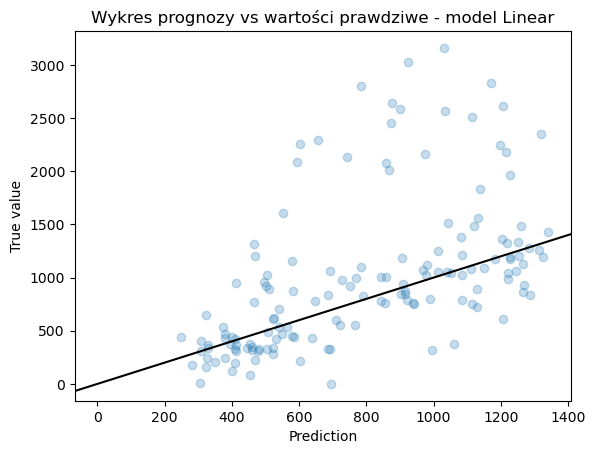

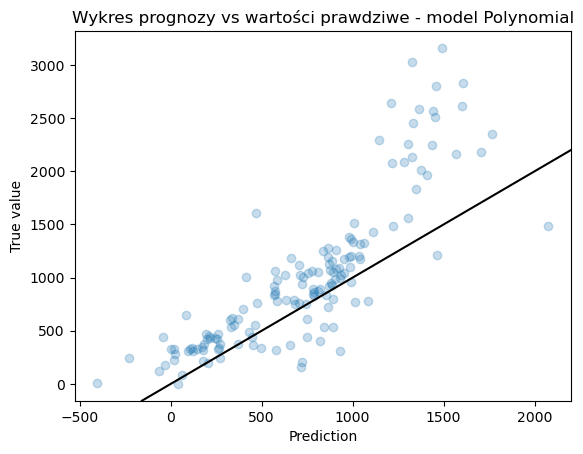

In [28]:
plt.scatter(x = y_predict_test, y = y_test, alpha=0.25)
plt.axline((0, 0), slope=1,color='black')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.title(f'Wykres prognozy vs wartości prawdziwe - model Linear')
plt.show()

plt.scatter(x = predictions_test, y = y_test, alpha=0.25)
plt.axline((0, 0), slope=1,color='black')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.title(f'Wykres prognozy vs wartości prawdziwe - model Polynomial')
plt.show()

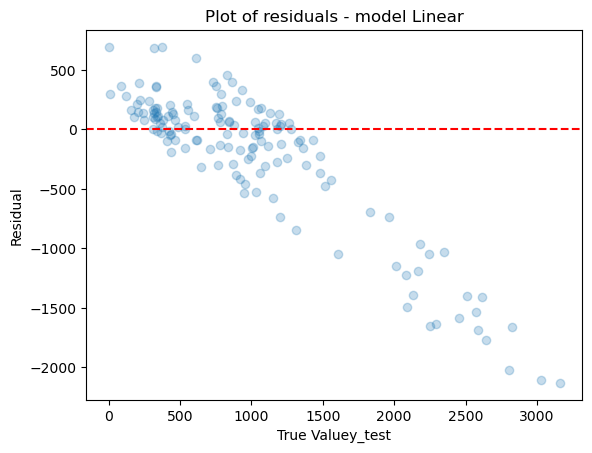

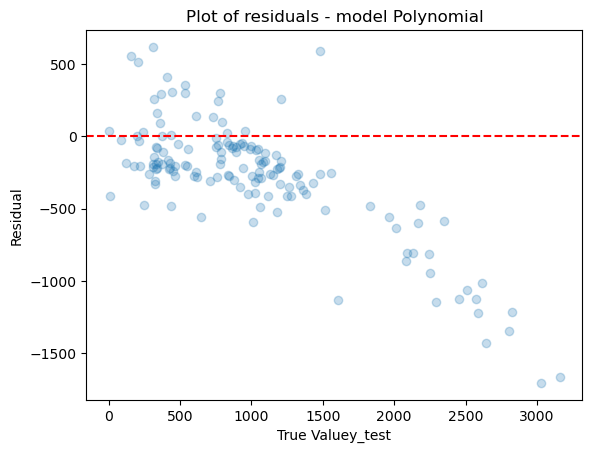

In [30]:
errors = y_predict_test - y_test
plt.scatter(x = y_test, y = errors, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Valuey_test')
plt.ylabel('Residual')
plt.title(f'Plot of residuals - model Linear')
plt.show()

errors = predictions_test - y_test
plt.scatter(x = y_test, y = errors, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Valuey_test')
plt.ylabel('Residual')
plt.title(f'Plot of residuals - model Polynomial')
plt.show()

# Wnioski:

Przy porównaniu metryk model Polynomial wypada zdecydowanie lepiej. Widać to juz po współczynniku determinacji R^2. W przypadku Linear był zupełnie niezadowalający (wynosił 0.306179), przy modelu Polynomial jest już zadowalający, ponieważ wyjaśnia 0.701074 modelu. Podobnie z pozostałymi metrykami. Błędy, różnice są mniejsze. Tam, gdzie model mylił się o niemal 300% (test_MAPE) - teraz myli się o ok. 86%. Różnica między test_RMSE a test_MAE zmniejszyła się znacząco.

Na wykresach prognoz w stosunku do wartości prawdziwych punkty zblizyły się do linii oznaczającej idealne odzwierciedlenie. W przypadku modelu Linear punkty były rozproszone po niemal całym polu wykresu. W modelu Polynomial mniejsze wartości rentals (tak do ok. 1200) układają się wokół linii. Wyższe wartości są wciąż rozproszone i oddalone - jednak jest ich mniej.

Na wykresach reszt widać, że tendencja z modelu Linear zaczęła się "rozsypywać". Punkty przestały się tak wyrażnie układać w linię, a zaczęły się kumulować w lewej górnej ćwiartce wykresu.